
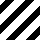
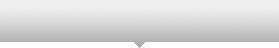
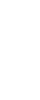
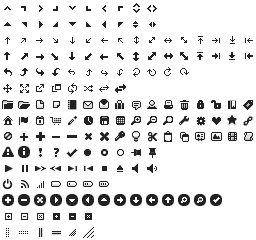
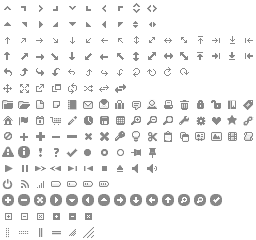
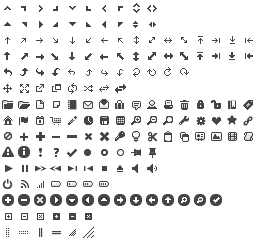
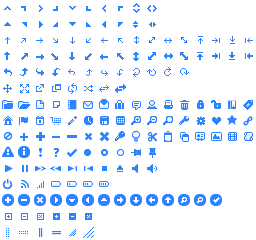
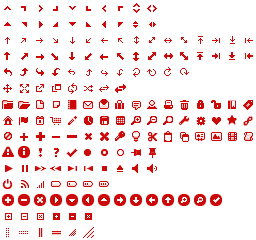
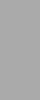
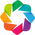
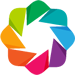
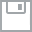
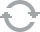
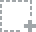
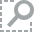
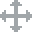
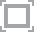
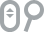

In [2]:
from __future__ import division
import glob
from datetime import datetime, timedelta
import os

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pandas import DataFrame, Series
import pandas as pd

import dask.dataframe as dd
from dask.diagnostics import ProgressBar
ProgressBar().register()
from castra import Castra

from mpl_toolkits.basemap import Basemap

from bokeh.plotting import figure, show, output_notebook
output_notebook()

import statsmodels.api as sm
import folium

import seaborn as sns

%matplotlib inline
matplotlib.rcParams['svg.fonttype'] = 'none'

In [3]:
date_parser = lambda x: datetime.strptime(x, '%Y%m%d')

CATEGORIES = ['Station', 'Komponente','TYPE_OF_AREA', 'TYPE_OF_STATION', 'TYPE_OF_DATA', 'Lieferung']
ID_VARS = list(CATEGORIES) + ['Datum']
VALUES = ['Wert{:02d}'.format(i) for i in range(1, 25)]

date_format = "%Y%m%d %H"

def create_dataframe():
    df = dd.read_csv('data/DE*.csv', encoding='latin1', sep=';', quotechar="'", na_values=['', '-999', '-111'],
                     parse_dates=['Datum'], date_parser=date_parser, index_col=False)

    df = df.compute()
    print('Make categories...')
    for c in CATEGORIES:
        df[c] = df[c].astype('category')

    print('Melting values...')
    df = pd.melt(df, id_vars=ID_VARS, value_vars=VALUES, var_name='hour', value_name='value')
    print('Converting hour column...')
    hours = df.hour.map(lambda x: x[4:]).convert_objects(convert_numeric=True) - 1
    hours = pd.to_timedelta(hours, unit='h')
    print('Applying hour to date column...')
    df['date'] = df.Datum + hours
    df = df.drop(['Datum', 'hour'], axis=1)
    print('Setting index...')
    df = df.set_index('date')
    return df

def get_daskframe(path='stickoxide.castra'):
    if not os.path.exists(path):
        print('Castra path "%s" not found, recreating...' % path)
        df = create_dataframe()
        print('Writing castra file...')
        c = Castra(path, template=df, categories=True)
        c.extend(df)
        return c.to_dask()
    c = Castra(path=path)
    return c.to_dask()

dfk = get_daskframe()
df = dfk.compute()
df.head()

[########################################] | 100% Completed |  1.1s


,Station,Komponente,TYPE_OF_AREA,TYPE_OF_STATION,TYPE_OF_DATA,Lieferung,value
date,,,,,,,
2009-01-01,DEBB007,Stickstoffdioxid,vorstädtisches Gebiet,Hintergrund,H,Y,23.2
2009-01-01,DERP011,Stickstoffdioxid,städtisches Gebiet,Verkehr,H,Y,49.3
2009-01-01,DERP010,Stickstoffdioxid,städtisches Gebiet,Verkehr,H,Y,49.5
2009-01-01,DERP009,Stickstoffdioxid,städtisches Gebiet,Hintergrund,H,Y,41.7
2009-01-01,DERP008,Stickstoffdioxid,städtisches Gebiet,Hintergrund,H,Y,42.7


In [4]:
german_date_parser = lambda x: datetime.strptime(x, '%d.%m.%Y')
stations = pd.read_csv('data/station_All.csv', encoding='latin1', sep=';', quotechar='"', skiprows=1, parse_dates=[4, 5], date_parser=german_date_parser)
stations[u'Aktivitätsperiode: bis'] = stations[u'Aktivitätsperiode: bis'].convert_objects(convert_dates='coerce')
stations[u'lng'] = stations[u'Länge dezimal'].str.replace(',', '.').convert_objects(convert_numeric=True)
stations[u'lat'] = stations[u'Breite dezimal'].str.replace(',', '.').convert_objects(convert_numeric=True)
stations['height'] = stations[u'Höhe'].convert_objects(convert_numeric=True)
stations['ags'] = stations[u'Amtlicher Gemeindeschlüssel (AGS)'].dropna().apply(lambda x: '{:0>5d}'.format(int(str(x)[:5])))
stations = stations.rename(columns={'Stationscode': 'Station'})
stations.head()

,Station,Stationsname,Kategorie,Synonym,Aktiv seit,Aktivitätsperiode: von,Aktivitätsperiode: bis,Verlegt,Straße,Nr,...,Quelle 1 (Hauptquelle) - ID,Gasförmige Schadstoffe,Partikelförmige Schadstoffe,Deposition,Umweltmonitoring-Typ,Unnamed: 44,lng,lat,height,ags
0,DEBB001,Burg (Spreewald),Luftmessstation,BUCH,1993-01-01,1993-01-01,2003-05-19,nein,Bahnhofstr.,9,...,no,"3,5","3,5",NaN,k.A.,NaN,14.141703,51.837590,54,12071
1,DEBB002,Brandenburg-Nord,Luftmessstation,BRGU,1991-02-01,1991-02-01,1994-06-30,nein,GutsMuthsstraße,NaN,...,no,"3,5",NaN,NaN,k.A.,NaN,12.560379,52.420960,31,12051
2,DEBB003,Brandenburg a.d. Havel,Luftmessstation,BRPI,1991-03-01,1991-03-01,2001-07-06,nein,Gertrud-Pieter-Platz,9,...,1A3,"3,5","3,5",NaN,k.A.,NaN,12.544441,52.412114,33,12051
3,DEBB004,Cottbus-LUA,Luftmessstation,COUA,1991-01-01,1991-01-01,2003-12-31,nein,Am Nordrand,45,...,no,"3,5",NaN,NaN,k.A.,NaN,14.327692,51.778045,68,12052
4,DEBB005,Cottbus-City (-Mitte),Luftmessstation,COCY,1991-01-01,1991-01-01,1997-03-31,nein,Karl-Liebknecht-Str.,136,...,no,"3,5","3,5",NaN,k.A.,NaN,14.331685,51.757900,74,12052


In [5]:
germany_bbox = {
  'lon': 10.45415,
  'lat': 51.164181,
  'll_lon': 5.86624,
  'll_lat': 47.27021,
  'ur_lon': 15.04205,
  'ur_lat': 55.05814
}

def shifted_color_map(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower ofset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax/(vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highets point in the colormap's range.
          Defaults to 1.0 (no upper ofset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap

def plot_map(df, vals='value', cmap='cool', diverging=False, bbox=germany_bbox):
    if diverging:
        vmin = df[vals].min()
        vmax = df[vals].max()
        midrange = 1 - vmax / (vmax + abs(vmin))
        cmap = shifted_color_map(matplotlib.cm.get_cmap(cmap), midpoint=midrange)
        
    markersize = 40
    markertype = 'o'  # pixel
    markercolor = '#325CA9'  # blue
    if vals is not None:
        markercolor = df[vals].as_matrix()
    markeralpha = .75 #  a bit of transparency

    fig = plt.figure(figsize=(10,16))
    m = Basemap(
      projection='mill', lon_0=bbox['lon'], lat_0=bbox['lat'],
      llcrnrlon=bbox['ll_lon'], llcrnrlat=bbox['ll_lat'],
      urcrnrlon=bbox['ur_lon'], urcrnrlat=bbox['ur_lat'],
      resolution='l'
    )
    m.drawmapboundary(fill_color='#ffffff', linewidth=.0)
    x, y = m(df.lng.as_matrix(), df.lat.as_matrix())
    m.drawcoastlines()
    m.drawcountries()
    m.scatter(x, y, markersize, marker=markertype,  cmap=cmap, c=markercolor, alpha=markeralpha)
    m.colorbar()
    return m


In [6]:
# Span of dataset: 01.01.2009 - 30.09.2015
df.reset_index().date.describe()

count                25579824
unique                  59136
top       2015-07-01 09:00:00
freq                      810
first     2009-01-01 00:00:00
last      2015-09-30 23:00:00
Name: date, dtype: object

In [7]:
df.Komponente.value_counts()

Stickstoffdioxid    25579824
dtype: int64

In [8]:
df.TYPE_OF_AREA.value_counts()

städtisches Gebiet       15244776
vorstädtisches Gebiet     5227848
ländliches Gebiet         2089944
ländlich regional         1660608
ländlich stadtnah          977040
ländlich abgelegen         379608
dtype: int64

In [9]:
df.TYPE_OF_STATION.value_counts()

Hintergrund    15484272
Verkehr         8594928
Industrie       1500624
dtype: int64

In [10]:
df.TYPE_OF_DATA.value_counts()

# S = Stundendaten
# H = Halbstündlich
# T = Tagesdaten

S    17113440
H     8203440
T      262944
dtype: int64

## Map of all stations coloured by their median measurement 2015

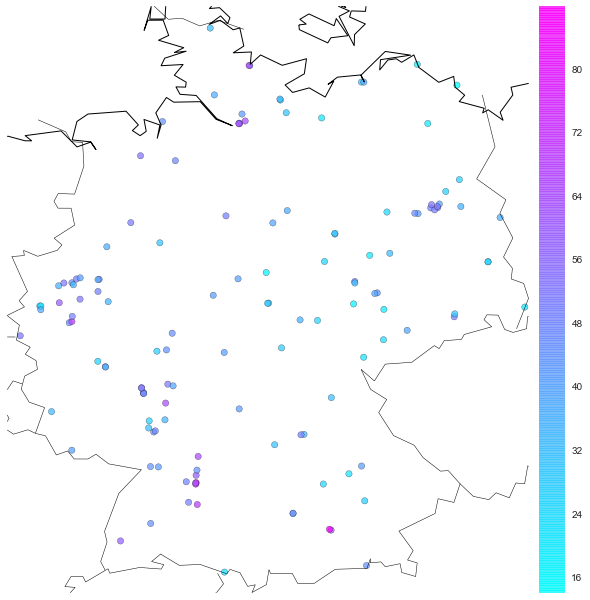

In [11]:
filtered = df[(df.index.year == 2015) & (df.TYPE_OF_STATION == 'Verkehr')]
filtered = filtered.groupby('Station')
filtered = filtered.value.mean().reset_index()
filtered = filtered.merge(stations, on='Station')
plot_map(filtered, 'value')

## All stations with their 2015 mean value greater than 40.

That means that half of all measurements in 2015 were greater than 50!

In [12]:
filtered[filtered.value > 40].sort_index(by='value', ascending=False)

,Station,value,Stationsname,Kategorie,Synonym,Aktiv seit,Aktivitätsperiode: von,Aktivitätsperiode: bis,Verlegt,Straße,...,Quelle 1 (Hauptquelle) - ID,Gasförmige Schadstoffe,Partikelförmige Schadstoffe,Deposition,Umweltmonitoring-Typ,Unnamed: 44,lng,lat,height,ags
218,DEBW118,87.904302,Stuttgart Am Neckartor (S),Luftmessstation,NaN,2003-12-23,2003-12-23,NaT,NaN,Am Neckartor,...,1A3,"3,5","3,5",NaN,k.A.,NaN,9.191010,48.788100,239,81110
386,DEBY115,86.088847,München/Landshuter Allee,Luftmessstation,NaN,2004-07-01,2004-07-01,NaT,nein,Landshuter Allee,...,1A3,"3,9","4,5",NaN,k.A.,NaN,11.536513,48.149606,521,91620
220,DEBW116,76.653024,Stuttgart Hohenheimer Straße (S),Luftmessstation,NaN,2003-12-23,2003-12-23,NaT,NaN,Hohenheimer Straße,...,1A3,"3,5","3,5",NaN,k.A.,NaN,9.184490,48.768710,302,81110
266,DEBW147,69.932265,Reutlingen Lederstraße Ost (S),Luftmessstation,NaN,2007-03-21,2007-03-21,NaT,NaN,Lederstraße,...,1A3,"3,5","3,5",NaN,k.A.,NaN,9.210790,48.489330,382,84150
19,DENW211,68.187713,Köln Clevischer Ring 3,Luftmessstation,NaN,2006-05-06,2006-05-06,NaT,NaN,Clevischer Ring,...,1A3,"3,5","3,5",NaN,k.A.,NaN,7.004590,50.962857,48,53150
480,DESH052,67.653610,Kiel-Theodor-Heuss-Ring,Luftmessstation,NaN,2012-01-01,2012-01-01,NaT,NaN,Theodor-Heuss-Ring,...,1A3,"1,5",NaN,NaN,k.A.,NaN,10.122364,54.304242,18,10020
474,DEBW152,64.964458,Heilbronn Weinsberger Straße Ost (S),Luftmessstation,NaN,2009-01-01,2009-01-01,NaT,NaN,Weinsberger Straße,...,1A3,"3,5","3,5",NaN,k.A.,NaN,9.225890,49.146000,165,81210
247,DEBY037,64.703293,München/Stachus,Luftmessstation,NaN,1978-01-01,1978-01-01,NaT,nein,Sonnenstraße,...,1A3,"3,8","4,5",NaN,k.A.,NaN,11.564924,48.137252,521,91620
411,DEHE040,64.501240,Darmstadt-Hügelstraße,Luftmessstation,NaN,1993-11-01,1993-11-01,NaT,nein,Hügelstr.,...,1A3,"3,5","3,5",NaN,k.A.,NaN,8.653745,49.869457,158,64110
369,DEHH070,64.315990,Hamburg Max-Brauer-Allee II (Straße),Luftmessstation,70MB,2002-03-01,2002-03-01,NaT,nein,Max-Brauer-Allee,...,1A3,"1,5","3,5",NaN,k.A.,NaN,9.943012,53.555668,25,20000


## Top 20 highest measurements in dataset

"DENW116" (Krefeld (Hafen), Luftmessstation, Geo: 51.342561, 6.670195):

A fire seems to be the cause:
http://feuerwehr-herscheid.de/eins%C3%A4tze/2012/krefeld-26-09-12/
https://www.derwesten.de/staedte/duisburg/loescharbeiten-in-duengemittelfabrik-werden-noch-tage-dauern-id7135294.html
https://www.derwesten.de/staedte/nachrichten-aus-wesel-hamminkeln-und-schermbeck/-id7133204.html

Despite reports, the values indicate that air pollution was at unhealthy levels!

Site of fire and site of detector:
https://www.bing.com/maps/#Y3A9NTEuMDAwMDAwfjkuMDAwMDAwJmx2bD01JnN0eT1yJndoZXJlMT01MSVDMiVCMDIwJzMzLjIlMjJOJTIwNiVDMiVCMDQwJzEyLjclMjJF


In [13]:
df.sort_index(by='value', ascending=False).head(20).reset_index().merge(stations[['Station', 'Ort']], on='Station')

,date,Station,Komponente,TYPE_OF_AREA,TYPE_OF_STATION,TYPE_OF_DATA,Lieferung,value,Ort
0,2012-09-26 00:00:00,DENW116,Stickstoffdioxid,vorstädtisches Gebiet,Industrie,S,Y,1346.706000,Krefeld
1,2012-09-26 05:00:00,DENW116,Stickstoffdioxid,vorstädtisches Gebiet,Industrie,S,Y,1294.062000,Krefeld
2,2012-09-25 23:00:00,DENW116,Stickstoffdioxid,vorstädtisches Gebiet,Industrie,S,Y,1275.116000,Krefeld
3,2012-09-26 01:00:00,DENW116,Stickstoffdioxid,vorstädtisches Gebiet,Industrie,S,Y,1206.955000,Krefeld
4,2012-09-26 03:00:00,DENW116,Stickstoffdioxid,vorstädtisches Gebiet,Industrie,S,Y,1088.394000,Krefeld
5,2012-09-26 04:00:00,DENW116,Stickstoffdioxid,vorstädtisches Gebiet,Industrie,S,Y,987.990000,Krefeld
6,2012-09-26 06:00:00,DENW116,Stickstoffdioxid,vorstädtisches Gebiet,Industrie,S,Y,985.045000,Krefeld
7,2012-09-27 02:00:00,DENW116,Stickstoffdioxid,vorstädtisches Gebiet,Industrie,S,Y,900.788000,Krefeld
8,2012-09-25 21:00:00,DENW116,Stickstoffdioxid,vorstädtisches Gebiet,Industrie,S,Y,879.932000,Krefeld
9,2012-09-27 01:00:00,DENW116,Stickstoffdioxid,vorstädtisches Gebiet,Industrie,S,Y,875.983000,Krefeld


## Top 20 highest measurements in 2015

In [14]:
df[df.index.year == 2015].sort_index(by='value', ascending=False).head(20).reset_index().merge(stations[['Station', 'Ort']], on='Station')

,date,Station,Komponente,TYPE_OF_AREA,TYPE_OF_STATION,TYPE_OF_DATA,Lieferung,value,Ort
0,2015-01-31 14:00:00,DERP010,Stickstoffdioxid,städtisches Gebiet,Verkehr,S,M,372.517212,Mainz
1,2015-08-13 16:00:00,DEHE040,Stickstoffdioxid,städtisches Gebiet,Verkehr,S,M,337.881470,Darmstadt
2,2015-08-06 18:00:00,DEHE040,Stickstoffdioxid,städtisches Gebiet,Verkehr,S,M,333.430298,Darmstadt
3,2015-08-13 17:00:00,DEHE040,Stickstoffdioxid,städtisches Gebiet,Verkehr,S,M,317.605316,Darmstadt
4,2015-08-07 18:00:00,DEHE040,Stickstoffdioxid,städtisches Gebiet,Verkehr,S,M,311.622742,Darmstadt
5,2015-08-06 16:00:00,DEHE040,Stickstoffdioxid,städtisches Gebiet,Verkehr,S,M,291.012329,Darmstadt
6,2015-08-07 12:00:00,DEHE040,Stickstoffdioxid,städtisches Gebiet,Verkehr,S,M,286.764282,Darmstadt
7,2015-08-06 17:00:00,DEHE040,Stickstoffdioxid,städtisches Gebiet,Verkehr,S,M,280.635712,Darmstadt
8,2015-08-06 15:00:00,DEHE040,Stickstoffdioxid,städtisches Gebiet,Verkehr,S,M,279.584900,Darmstadt
9,2015-07-03 18:00:00,DEHE040,Stickstoffdioxid,städtisches Gebiet,Verkehr,S,M,269.313965,Darmstadt


In [15]:
stations[stations.Station == 'DEBW099']

,Station,Stationsname,Kategorie,Synonym,Aktiv seit,Aktivitätsperiode: von,Aktivitätsperiode: bis,Verlegt,Straße,Nr,...,Quelle 1 (Hauptquelle) - ID,Gasförmige Schadstoffe,Partikelförmige Schadstoffe,Deposition,Umweltmonitoring-Typ,Unnamed: 44,lng,lat,height,ags
257,DEBW099,Stuttgart_Arnulf-Klett-Platz,Luftmessstation,NaN,1994-12-06,1994-12-06,NaT,nein,Arnulf-Klett-Platz,NaN,...,1A3,"3,5","3,5",NaN,k.A.,NaN,9.18072,48.78313,244,81110


## Cross-checking

[This report](http://www.umweltbundesamt.de/sites/default/files/medien/358/dokumente/no2_2014_0.pdf) contains Jahresmittelwert and number of occasions when Stundenmittelwerte exceeded 200. Cross-checking some values from the table.

In [16]:
filtered = df[(df.Station == 'DEBW152') & (df.index.year == 2014)]
filtered.value.mean()

65.087167070217916

In [17]:
filtered[filtered.value > 200]

,Station,Komponente,TYPE_OF_AREA,TYPE_OF_STATION,TYPE_OF_DATA,Lieferung,value
date,,,,,,,
2014-11-03 08:00:00,DEBW152,Stickstoffdioxid,städtisches Gebiet,Verkehr,S,Y,219


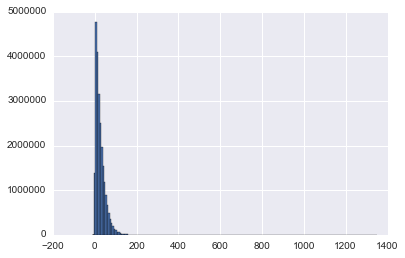

In [18]:
df.value.hist(bins=200)

TODO
 - Stacked Line Chart für Messstationen von Kreisen (Kreis)
 - Autobahnen, Schiffe, Heimöfen?

## Stationen mit mehr als 40 µg/m^3 in 2015

In [19]:
df_2015 = df[df.index.year == 2015]
mean_2015 = df_2015.groupby('Station').value.mean()
exceeding_40 = mean_2015[mean_2015 > 40].reset_index()
stations_exceeding_40 = exceeding_40.merge(stations, on='Station')
stations_exceeding_40.sort_index(by='value', ascending=False)

,Station,value,Stationsname,Kategorie,Synonym,Aktiv seit,Aktivitätsperiode: von,Aktivitätsperiode: bis,Verlegt,Straße,...,Quelle 1 (Hauptquelle) - ID,Gasförmige Schadstoffe,Partikelförmige Schadstoffe,Deposition,Umweltmonitoring-Typ,Unnamed: 44,lng,lat,height,ags
20,DEBW118,87.904302,Stuttgart Am Neckartor (S),Luftmessstation,NaN,2003-12-23,2003-12-23,NaT,NaN,Am Neckartor,...,1A3,"3,5","3,5",NaN,k.A.,NaN,9.191010,48.788100,239,81110
50,DEBY115,86.088847,München/Landshuter Allee,Luftmessstation,NaN,2004-07-01,2004-07-01,NaT,nein,Landshuter Allee,...,1A3,"3,9","4,5",NaN,k.A.,NaN,11.536513,48.149606,521,91620
22,DEBW116,76.653024,Stuttgart Hohenheimer Straße (S),Luftmessstation,NaN,2003-12-23,2003-12-23,NaT,NaN,Hohenheimer Straße,...,1A3,"3,5","3,5",NaN,k.A.,NaN,9.184490,48.768710,302,81110
30,DEBW147,69.932265,Reutlingen Lederstraße Ost (S),Luftmessstation,NaN,2007-03-21,2007-03-21,NaT,NaN,Lederstraße,...,1A3,"3,5","3,5",NaN,k.A.,NaN,9.210790,48.489330,382,84150
2,DENW211,68.187713,Köln Clevischer Ring 3,Luftmessstation,NaN,2006-05-06,2006-05-06,NaT,NaN,Clevischer Ring,...,1A3,"3,5","3,5",NaN,k.A.,NaN,7.004590,50.962857,48,53150
66,DESH052,67.653610,Kiel-Theodor-Heuss-Ring,Luftmessstation,NaN,2012-01-01,2012-01-01,NaT,NaN,Theodor-Heuss-Ring,...,1A3,"1,5",NaN,NaN,k.A.,NaN,10.122364,54.304242,18,10020
64,DEBW152,64.964458,Heilbronn Weinsberger Straße Ost (S),Luftmessstation,NaN,2009-01-01,2009-01-01,NaT,NaN,Weinsberger Straße,...,1A3,"3,5","3,5",NaN,k.A.,NaN,9.225890,49.146000,165,81210
28,DEBY037,64.703293,München/Stachus,Luftmessstation,NaN,1978-01-01,1978-01-01,NaT,nein,Sonnenstraße,...,1A3,"3,8","4,5",NaN,k.A.,NaN,11.564924,48.137252,521,91620
53,DEHE040,64.501240,Darmstadt-Hügelstraße,Luftmessstation,NaN,1993-11-01,1993-11-01,NaT,nein,Hügelstr.,...,1A3,"3,5","3,5",NaN,k.A.,NaN,8.653745,49.869457,158,64110
47,DEHH070,64.315990,Hamburg Max-Brauer-Allee II (Straße),Luftmessstation,70MB,2002-03-01,2002-03-01,NaT,nein,Max-Brauer-Allee,...,1A3,"1,5","3,5",NaN,k.A.,NaN,9.943012,53.555668,25,20000


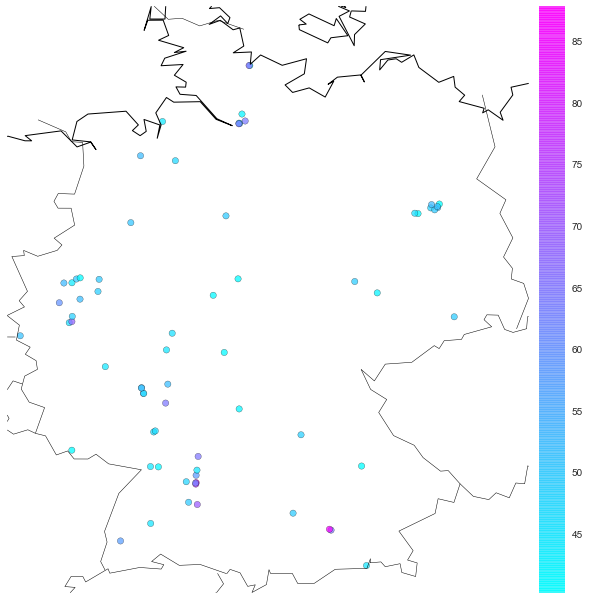

In [20]:
plot_map(stations_exceeding_40, 'value')

Kann man denn vom Mittelwert 2015 schon auf den Gesamtjahresmittelwert schließen? Nein, natürlich nicht. Aber die Tendenz ist, dass die Stickoxide im Winter steigen. Hier die Monatsmittelwerte aller Jahre im Datensatz.

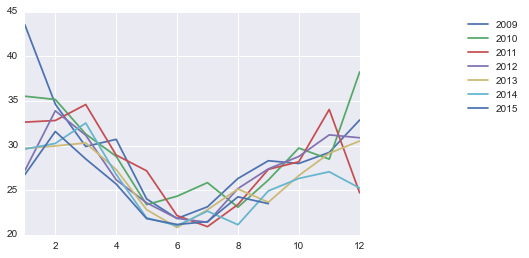

In [61]:
for year, grouped in df.groupby(df.index.year):
    grouped.groupby(grouped.index.month).value.mean().plot(label=year)
plt.legend(bbox_to_anchor=(1.5,1))

## Stationen 2015 mit Anzahl Überschreitungen von Stundenwerten 200 µg/m^3 bis zum 30.9.

In [22]:
greater_200 = df[df.value > 200]
exceeding_200_count = (greater_200.groupby([greater_200.index.year, greater_200.Station.astype(str)])
                        .value.count().reset_index().rename(columns={'level_0': 'jahr', 'value': 'anzahl'}))

exceeding_200_in_2015 = exceeding_200_count[(exceeding_200_count.jahr == 2015)]

exceeding_stations_2015 = exceeding_200_in_2015.merge(stations, on='Station')
exceeding_stations_2015.sort_index(by='anzahl', ascending=False)

,jahr,Station,anzahl,Stationsname,Kategorie,Synonym,Aktiv seit,Aktivitätsperiode: von,Aktivitätsperiode: bis,Verlegt,...,Quelle 1 (Hauptquelle) - ID,Gasförmige Schadstoffe,Partikelförmige Schadstoffe,Deposition,Umweltmonitoring-Typ,Unnamed: 44,lng,lat,height,ags
12,2015,DEHE040,77,Darmstadt-Hügelstraße,Luftmessstation,NaN,1993-11-01,1993-11-01,NaT,nein,...,1A3,"3,5","3,5",NaN,k.A.,NaN,8.653745,49.869457,158,64110
6,2015,DEBW118,59,Stuttgart Am Neckartor (S),Luftmessstation,NaN,2003-12-23,2003-12-23,NaT,NaN,...,1A3,"3,5","3,5",NaN,k.A.,NaN,9.191010,48.788100,239,81110
10,2015,DEBY115,45,München/Landshuter Allee,Luftmessstation,NaN,2004-07-01,2004-07-01,NaT,nein,...,1A3,"3,9","4,5",NaN,k.A.,NaN,11.536513,48.149606,521,91620
26,2015,DESH052,26,Kiel-Theodor-Heuss-Ring,Luftmessstation,NaN,2012-01-01,2012-01-01,NaT,NaN,...,1A3,"1,5",NaN,NaN,k.A.,NaN,10.122364,54.304242,18,10020
5,2015,DEBW116,17,Stuttgart Hohenheimer Straße (S),Luftmessstation,NaN,2003-12-23,2003-12-23,NaT,NaN,...,1A3,"3,5","3,5",NaN,k.A.,NaN,9.184490,48.768710,302,81110
23,2015,DERP011,13,Mainz-Rheinallee,Luftmessstation,NaN,1987-02-19,1987-02-19,NaT,nein,...,1A3,"3,5","3,5",NaN,k.A.,NaN,8.265563,50.009954,85,73150
15,2015,DEHH068,9,Hamburg Habichtstraße,Luftmessstation,68HB,2002-01-01,2002-01-01,NaT,nein,...,1A3,"1,5","3,5",NaN,k.A.,NaN,10.053859,53.592301,12,20000
13,2015,DEHE041,9,Frankfurt-Friedb.Ldstr.,Luftmessstation,NaN,1993-03-01,1993-03-01,NaT,nein,...,1A3,"3,5","3,5",NaN,k.A.,NaN,8.691911,50.124589,119,64120
22,2015,DERP010,8,Mainz-Parcusstraße,Luftmessstation,NaN,1979-01-01,1979-01-01,NaT,nein,...,1A3,"3,5","3,5",NaN,k.A.,NaN,8.261277,50.000973,85,73150
16,2015,DEHH070,6,Hamburg Max-Brauer-Allee II (Straße),Luftmessstation,70MB,2002-03-01,2002-03-01,NaT,nein,...,1A3,"1,5","3,5",NaN,k.A.,NaN,9.943012,53.555668,25,20000


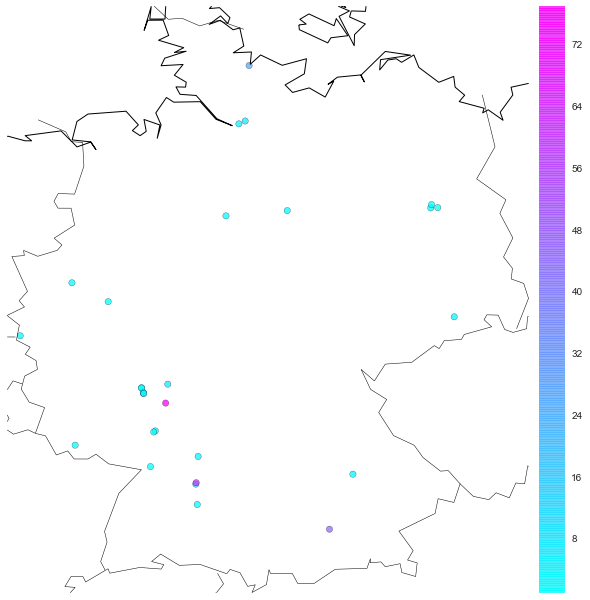

In [23]:
plot_map(exceeding_stations_2015, 'anzahl')

## Stationen 2015 mit Anzahl Überschreitungen von Stundenwerten 100 µg/m^3 bis zum 30.9.

In [24]:
greater_100 = df[df.value > 100]
exceeding_100_count = (greater_100.groupby([greater_100.index.year, greater_100.Station.astype(str)])
                        .value.count().reset_index().rename(columns={'level_0': 'jahr', 'value': 'anzahl'}))

exceeding_100_in_2015 = exceeding_100_count[(exceeding_100_count.jahr == 2015)]

exceeding_100_stations_2015 = exceeding_200_in_2015.merge(stations, on='Station')
exceeding_100_stations_2015.sort_index(by='anzahl', ascending=False)

,jahr,Station,anzahl,Stationsname,Kategorie,Synonym,Aktiv seit,Aktivitätsperiode: von,Aktivitätsperiode: bis,Verlegt,...,Quelle 1 (Hauptquelle) - ID,Gasförmige Schadstoffe,Partikelförmige Schadstoffe,Deposition,Umweltmonitoring-Typ,Unnamed: 44,lng,lat,height,ags
12,2015,DEHE040,77,Darmstadt-Hügelstraße,Luftmessstation,NaN,1993-11-01,1993-11-01,NaT,nein,...,1A3,"3,5","3,5",NaN,k.A.,NaN,8.653745,49.869457,158,64110
6,2015,DEBW118,59,Stuttgart Am Neckartor (S),Luftmessstation,NaN,2003-12-23,2003-12-23,NaT,NaN,...,1A3,"3,5","3,5",NaN,k.A.,NaN,9.191010,48.788100,239,81110
10,2015,DEBY115,45,München/Landshuter Allee,Luftmessstation,NaN,2004-07-01,2004-07-01,NaT,nein,...,1A3,"3,9","4,5",NaN,k.A.,NaN,11.536513,48.149606,521,91620
26,2015,DESH052,26,Kiel-Theodor-Heuss-Ring,Luftmessstation,NaN,2012-01-01,2012-01-01,NaT,NaN,...,1A3,"1,5",NaN,NaN,k.A.,NaN,10.122364,54.304242,18,10020
5,2015,DEBW116,17,Stuttgart Hohenheimer Straße (S),Luftmessstation,NaN,2003-12-23,2003-12-23,NaT,NaN,...,1A3,"3,5","3,5",NaN,k.A.,NaN,9.184490,48.768710,302,81110
23,2015,DERP011,13,Mainz-Rheinallee,Luftmessstation,NaN,1987-02-19,1987-02-19,NaT,nein,...,1A3,"3,5","3,5",NaN,k.A.,NaN,8.265563,50.009954,85,73150
15,2015,DEHH068,9,Hamburg Habichtstraße,Luftmessstation,68HB,2002-01-01,2002-01-01,NaT,nein,...,1A3,"1,5","3,5",NaN,k.A.,NaN,10.053859,53.592301,12,20000
13,2015,DEHE041,9,Frankfurt-Friedb.Ldstr.,Luftmessstation,NaN,1993-03-01,1993-03-01,NaT,nein,...,1A3,"3,5","3,5",NaN,k.A.,NaN,8.691911,50.124589,119,64120
22,2015,DERP010,8,Mainz-Parcusstraße,Luftmessstation,NaN,1979-01-01,1979-01-01,NaT,nein,...,1A3,"3,5","3,5",NaN,k.A.,NaN,8.261277,50.000973,85,73150
16,2015,DEHH070,6,Hamburg Max-Brauer-Allee II (Straße),Luftmessstation,70MB,2002-03-01,2002-03-01,NaT,nein,...,1A3,"1,5","3,5",NaN,k.A.,NaN,9.943012,53.555668,25,20000


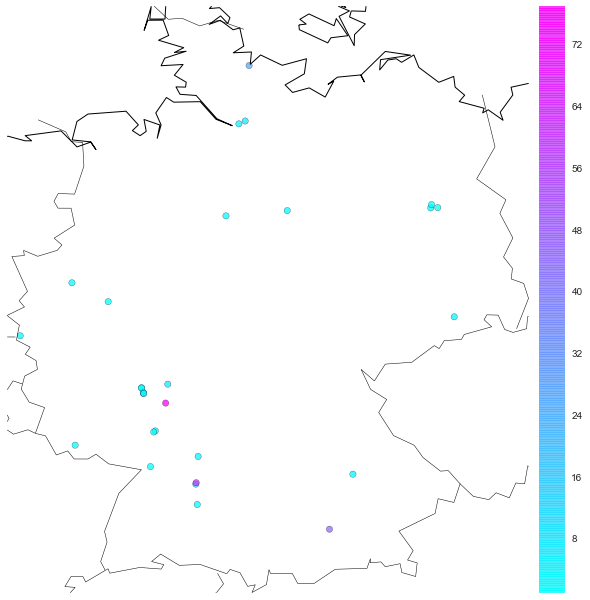

In [25]:
plot_map(exceeding_100_stations_2015, 'anzahl')

In [26]:
stuttgart_bbox = {
  'lon': 9.182778,
  'lat': 48.775556,
  'll_lon': 8.74641,
  'll_lat': 48.4975,
  'ur_lon': 10.4956,
  'ur_lat': 49.7913
}

def plot_stations(stations):
    mean_lat = stations.lat.mean()
    mean_lng = stations.lng.mean()
    fmap = folium.Map(location=[mean_lat, mean_lng], zoom_start=11, height=800)
    for i, station in stations.iterrows():
        fmap.circle_marker(location=[station.lat, station.lng], radius=50,
                    popup=u'{}: {}'.format(station.Stationsname, station.value), line_color='#f00',
                    fill_color='#f00')
    fmap.create_map(path='stuttgart.html')
    return fmap


filtered = df[df.index.year == 2015]
filtered = filtered.groupby('Station')
filtered = filtered.value.median().reset_index()
filtered = filtered.merge(stations, on='Station')

plot_stations(filtered)

In [27]:
stations[stations.ags == '81110']

,Station,Stationsname,Kategorie,Synonym,Aktiv seit,Aktivitätsperiode: von,Aktivitätsperiode: bis,Verlegt,Straße,Nr,...,Quelle 1 (Hauptquelle) - ID,Gasförmige Schadstoffe,Partikelförmige Schadstoffe,Deposition,Umweltmonitoring-Typ,Unnamed: 44,lng,lat,height,ags
179,DEBW011,Stuttgart-Zuffenhausen,Luftmessstation,NaN,1981-01-01,1981-01-01,2010-12-31,nein,Ludwigsburger-/Frankenstr.,NaN,...,1A3,"3,5","3,5",NaN,k.A.,NaN,9.172506,48.825575,272,81110
180,DEBW012,Stuttgart-Mitte,Luftmessstation,NaN,1981-01-01,1981-01-01,2000-06-30,nein,Hegel-/Lerchenstr.,NaN,...,no,"3,5","3,5",NaN,k.A.,NaN,9.164834,48.775865,260,81110
181,DEBW013,Stuttgart Bad Cannstatt,Luftmessstation,NaN,1981-01-01,1981-01-01,NaT,nein,Gnesenerstr./Seuberstr.,NaN,...,no,"3,5","3,5",NaN,k.A.,NaN,9.229745,48.808800,235,81110
182,DEBW014,Stuttgart-Hafen,Luftmessstation,NaN,1981-01-01,1981-01-01,2003-09-30,nein,Am Mittelkai,NaN,...,2,"3,5","3,5",NaN,k.A.,NaN,9.265529,48.752251,235,81110
257,DEBW099,Stuttgart_Arnulf-Klett-Platz,Luftmessstation,NaN,1994-12-06,1994-12-06,NaT,nein,Arnulf-Klett-Platz,NaN,...,1A3,"3,5","3,5",NaN,k.A.,NaN,9.180720,48.783130,244,81110
258,DEBW100,Stuttgart-Vaihingen-Straße,Luftmessstation,NaN,1994-01-01,1994-01-01,1999-02-23,nein,Möhringer Landstraße,NaN,...,1A3,"3,5","3,5",NaN,k.A.,NaN,9.113306,48.730066,410,81110
274,DEBW116,Stuttgart Hohenheimer Straße (S),Luftmessstation,NaN,2003-12-23,2003-12-23,NaT,NaN,Hohenheimer Straße,64,...,1A3,"3,5","3,5",NaN,k.A.,NaN,9.184490,48.768710,302,81110
276,DEBW118,Stuttgart Am Neckartor (S),Luftmessstation,NaN,2003-12-23,2003-12-23,NaT,NaN,Am Neckartor,NaN,...,1A3,"3,5","3,5",NaN,k.A.,NaN,9.191010,48.788100,239,81110
277,DEBW119,Stuttgart Siemensstraße (S),Luftmessstation,NaN,2003-12-23,2003-12-23,2007-12-31,NaN,Siemensstraße,43,...,1A3,"3,5","3,5",NaN,k.A.,NaN,9.175299,48.811099,296,81110
292,DEBW134,Stuttgart Waiblinger Straße,Luftmessstation,NaN,2004-01-01,2004-01-01,NaT,NaN,Waiblinger Straße,22,...,1A3,"3,5","3,5",NaN,k.A.,NaN,9.220360,48.803770,223,81110


## Tendenzen der Stationen über die Jahre

Generell geht es runter, im Schnitt -3µg/m^3 zwischen 2009 und 2014. Aber es gibt ~45 Messstationen, die 2014 schlechtere Jahresmittelwerte als 2009 haben.

In [28]:
df_2009 = df[df.index.year == 2009]
df_2014 = df[df.index.year == 2014]
stations_mean_2009 = df_2009.groupby('Station').value.mean()
stations_mean_2014 = df_2014.groupby('Station').value.mean()
stations_difference = stations_mean_2014 - stations_mean_2009
stations_difference.describe()

count    361.000000
mean      -3.828525
std        4.453329
min      -32.223841
25%       -5.316911
50%       -2.937584
75%       -1.043384
max        5.075042
Name: value, dtype: float64

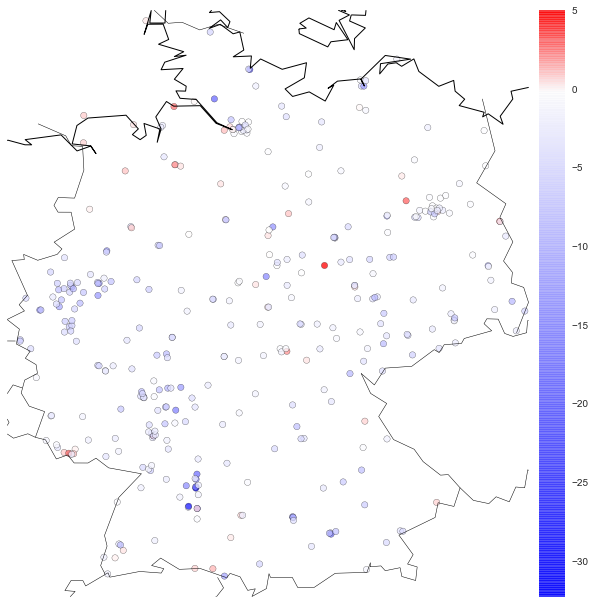

In [29]:
station_diff = stations_difference.reset_index().merge(stations, on="Station")
plot_map(station_diff, 'value', cmap='bwr', diverging=True)

In [30]:
station_diff.sort_index(by='value', ascending=False).head(50)

,Station,value,Stationsname,Kategorie,Synonym,Aktiv seit,Aktivitätsperiode: von,Aktivitätsperiode: bis,Verlegt,Straße,...,Quelle 1 (Hauptquelle) - ID,Gasförmige Schadstoffe,Partikelförmige Schadstoffe,Deposition,Umweltmonitoring-Typ,Unnamed: 44,lng,lat,height,ags
131,DEST095,5.075042,Aschersleben,Luftmessstation,NaN,2000-11-02,2000-11-02,NaT,ja,Hinter dem Zoll,...,1A3,"1,7","2,4",NaN,k.A.,NaN,11.449438,51.759554,125,15089
287,DEBB067,2.931137,Nauen,Luft- und Depositionsmessstation,NaN,2003-08-11,2003-08-11,NaT,NaN,Kreuztaler Str.,...,no,"3,5","3,5","1,5",k.A.,NaN,12.885194,52.608609,31,12063
142,DEBB042,2.849716,"Frankfurt (Oder), 1997-2014",Luftmessstation,FFMA,1997-04-21,1997-04-21,2014-05-05,nein,Markendorfer Str.,...,no,"3,5","3,5","1,5",k.A.,NaN,14.531918,52.339953,58,12053
181,DESL010,2.793254,Saarbrücken-Burbach,Luftmessstation,BURB,1983-07-01,1983-07-01,NaT,nein,Von-der-Heydt-Straße,...,no,"3,5","3,5",NaN,k.A.,NaN,6.948776,49.244247,211,10041
74,DENI059,2.602516,Elbmündung,Luftmessstation,NaN,1998-03-20,1998-03-20,NaT,nein,Wehldorfer Straße,...,no,"3,40","4,70",NaN,k.A.,NaN,8.801220,53.830170,3,33520
436,DEHB001,2.197203,Bremen-Mitte,Luftmessstation,NaN,1987-01-01,1987-01-01,NaT,ja,Präsident-Kennedy-Platz,...,no,"3,5","3,5",NaN,k.A.,NaN,8.815780,53.077151,10,40110
114,DETH040,2.087119,Großer Eisenberg,Luftmessstation,NaN,1994-12-04,1994-12-04,NaT,nein,--,...,no,"3,5",NaN,NaN,k.A.,NaN,10.787135,50.619181,907,16070
7,DERP002,2.062715,Ludwigshafen-Mitte,Luftmessstation,NaN,1978-01-01,1978-01-01,2014-01-15,nein,Neuer Messplatz,...,1A3,"3,5","3,5",NaN,k.A.,NaN,8.438589,49.482316,93,73140
241,DEBW038,1.428813,Friedrichshafen,Luftmessstation,NaN,1987-01-01,1987-01-01,NaT,nein,Ehlerstr./Polizeirevier,...,1A3,"3,5","3,5",NaN,k.A.,NaN,9.485675,47.660056,404,84350
71,DENI063,1.261382,Altes Land,Luftmessstation,NaN,1999-02-11,1999-02-11,NaT,nein,Ostfeld,...,no,"3,30","4,65",NaN,k.A.,NaN,9.685030,53.524180,3,33590


In [31]:
kreise = pd.read_csv('data/12411-0014.csv', skiprows=5, skipfooter=5, delimiter=';', encoding='latin-1')
kreise.rename(columns={'Unnamed: 0': 'ags', 'Unnamed: 1': 'Kreisname'}, inplace=True)
kreise['ags'] = kreise['ags'].apply(lambda x: '{:0>5d}'.format(x))
kreise = kreise[['ags', 'Kreisname']]
kreise.head()


/Users/sw/.virtualenvs/notebook/lib/python2.7/site-packages/pandas/io/parsers.py:648: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skip_footer; you can avoid this warning by specifying engine='python'.
  ParserWarning)


,ags,Kreisname
0,01001,"Flensburg, kreisfreie Stadt"
1,01002,"Kiel, kreisfreie Stadt"
2,01003,"Lübeck, kreisfreie Stadt"
3,01004,"Neumünster, kreisfreie Stadt"
4,01051,"Dithmarschen, Landkreis"


In [32]:
df_2009_ags = df_2009.merge(stations[['Station', 'ags']], on='Station').groupby('ags').value.mean()
df_2014_ags = df_2014.merge(stations[['Station', 'ags']], on='Station').groupby('ags').value.mean()

df_diff_ags = df_2014_ags - df_2009_ags
df_diff_ags = df_diff_ags.order(ascending=False)
df_diff_ags.describe()

count    224.000000
mean      -3.138674
std        4.649941
min      -21.422409
25%       -5.289598
50%       -2.598710
75%       -0.695285
max       18.016377
Name: value, dtype: float64

## Kreise, in denen es von 2009 - 2014 schlechter wurde

In [33]:
df_diff_ags_cleaned = df_diff_ags.reset_index()
df_diff_ags_cleaned.ags = (df_diff_ags_cleaned.ags.convert_objects(convert_numeric=True)
                                                  .apply(lambda x: int(x / 10.0))
                                                  .apply(lambda x: '{:05d}'.format(x)))
df_diff_ags_cleaned = df_diff_ags_cleaned.merge(kreise, on='ags')
df_diff_ags_cleaned = df_diff_ags_cleaned.sort_index(by='value', ascending=False)
df_diff_ags_cleaned.head(20)

,ags,value,Kreisname
0,03403,18.016377,"Oldenburg (Oldenburg), kreisfreie Stadt"
1,08121,15.077052,"Heilbronn, kreisfreie Stadt"
2,03103,10.735965,"Wolfsburg, kreisfreie Stadt"
3,08215,7.616578,"Karlsruhe, Landkreis"
4,05513,7.499909,"Gelsenkirchen, kreisfreie Stadt"
5,09663,6.660836,"Würzburg, kreisfreie Stadt"
6,07316,5.178678,"Neustadt an der Weinstraße, kreisfreie Stadt"
7,08226,2.629007,Rhein-Neckar-Kreis
8,03352,2.602516,"Cuxhaven, Landkreis"
9,01061,2.489519,"Steinburg, Landkreis"


In [34]:
df_diff_ags_cleaned.describe()

,value
count,157.000000
mean,-3.366817
std,5.301529
min,-21.422409
25%,-5.878348
50%,-2.991157
75%,-0.358820
max,18.016377


In [35]:
import folium

def make_kreise_map(geo_data, key='value', diverging=False, fill='PRGn'):

    # We use the geo json file for our metro we generated above
    # geo_path = r'kreise.geojson'
    geo_path = 'geodata/kreise.topo.json'
    
    geo_data = geo_data.copy()
    geo_data[key] *= -1

    min_val = geo_data[key].min()
    q1 = geo_data[key].quantile( .25)
    q2 = geo_data[key].quantile( .5)
    q3 = geo_data[key].quantile( .75)
    q4 = geo_data[key].quantile( .9)
    max_val = geo_data[key].max()
    scale = None
    if diverging:
        scale = [min_val, min_val / 2, 0, 1, max_val / 2, max_val]
        print(scale)
    else:
        scale = [min_val, q1, q2, q3, q4, max_val]

    m = folium.Map(location=[52, 10], zoom_start=6, height=800)
    m.geo_json(geo_path=geo_path, data=geo_data, data_out='%s_diff.json' % key,
                 columns=['ags', key],
                 threshold_scale=scale,
                 key_on='feature.properties.AGS',
                 fill_color=fill, fill_opacity=0.7, line_opacity=0.3,
                 legend_name='',
                 topojson='objects.kreise', reset=True
    )
    m.create_map(path='map_diff_pp.html')
    return m

### Tendenzen der Kreise

Grün: 2014 mehr als 2009, rosa: weniger, schwarz: unbekannt

In [36]:
make_kreise_map(df_diff_ags_cleaned, diverging=True)

[-18.016377378260103, -9.0081886891300513, 0, 1, 10.711204252485729, 21.422408504971457]


### Durchschnittswerte der Kreise 2015

In [37]:
df_2015_ags = df_2015.merge(stations[['ags', 'Station']], on='Station').groupby('ags').value.mean().reset_index()
df_2015_ags.ags = (df_2015_ags.ags.convert_objects(convert_numeric=True)
                                                  .apply(lambda x: int(x / 10.0))
                                                  .apply(lambda x: '{:05d}'.format(x)))
df_2015_ags = df_2015_ags.merge(kreise, on='ags')
df_2015_ags.sort_index(by='value', ascending=True).head(50)

,ags,value,Kreisname
123,08315,4.134968,"Breisgau-Hochschwarzwald, Landkreis"
7,01054,4.239412,"Nordfriesland, Landkreis"
146,09372,4.816684,"Cham, Landkreis"
105,07340,5.357505,"Südwestpfalz, Landkreis"
166,09780,5.483013,"Oberallgäu, Landkreis"
91,07134,5.556937,"Birkenfeld, Landkreis"
87,06636,5.823555,Werra-Meißner-Kreis
66,05970,5.834551,"Siegen-Wittgenstein, Landkreis"
27,03360,6.053056,"Uelzen, Landkreis"
95,07232,6.095001,Eifelkreis Bitburg-Prüm


In [38]:
make_kreise_map(df_2015_ags, fill='OrRd')

## Schlechteste Durchschnittswerte 2014

In [39]:
df_2014_ags = df_2014.merge(stations[['ags', 'Station']], on='Station').groupby('ags').value.mean().reset_index()
df_2014_ags.ags = (df_2014_ags.ags.convert_objects(convert_numeric=True)
                                                  .apply(lambda x: int(x / 10.0))
                                                  .apply(lambda x: '{:05d}'.format(x)))
df_2014_ags = df_2014_ags.merge(kreise, on='ags')
df_2014_ags.sort_index(by='value', ascending=False).head(50)

,ags,value,Kreisname
106,08111,64.435916,"Stuttgart, kreisfreie Stadt"
43,05119,54.946690,"Oberhausen, kreisfreie Stadt"
29,03403,53.850894,"Oldenburg (Oldenburg), kreisfreie Stadt"
62,05914,53.417531,"Hagen, kreisfreie Stadt"
110,08121,47.629498,"Heilbronn, kreisfreie Stadt"
71,06414,46.146803,"Wiesbaden, kreisfreie Stadt"
63,05916,45.682210,"Herne, kreisfreie Stadt"
109,08118,45.384638,"Ludwigsburg, Landkreis"
135,09162,45.081669,"München, kreisfreie Stadt"
10,01060,44.565346,"Segeberg, Landkreis"


# Explorations

In [40]:
stations[stations.Stationsname.str.contains(u'Heidelberg')]

,Station,Stationsname,Kategorie,Synonym,Aktiv seit,Aktivitätsperiode: von,Aktivitätsperiode: bis,Verlegt,Straße,Nr,...,Quelle 1 (Hauptquelle) - ID,Gasförmige Schadstoffe,Partikelförmige Schadstoffe,Deposition,Umweltmonitoring-Typ,Unnamed: 44,lng,lat,height,ags
177,DEBW009,Heidelberg,Luftmessstation,NaN,1984-01-01,1984-01-01,NaT,nein,Ecke Berliner-/Blumenthalstr.,NaN,...,1A3,"3,5","3,5",NaN,k.A.,NaN,8.676700,49.419528,112,82210
259,DEBW101,Heidelberg Schwimmbad,Luftmessstation,NaN,1994-07-01,1994-07-01,2009-06-10,nein,Tiergarten-Freibad,NaN,...,no,"3,5",NaN,NaN,k.A.,NaN,8.658185,49.421366,110,82210
282,DEBW124,Heidelberg Karlsruher Straße (S),Luftmessstation,NaN,2004-01-01,2004-01-01,2009-12-31,NaN,Karlsruher Straße,NaN,...,1A3,"3,5","3,5",NaN,k.A.,NaN,8.687180,49.379368,113,82210
309,DEBW151,Heidelberg Mittermaierstraße (S),Luftmessstation,NaN,2009-01-01,2009-01-01,NaT,NaN,Mittermaierstraße,NaN,...,1A3,"3,5","3,5",NaN,k.A.,NaN,8.677000,49.407250,117,82210
319,DEBW161,Forst_Heidelberg,Umweltmonitoring,Level II 802,2005-01-01,2005-01-01,NaT,NaN,NaN,NaN,...,no,NaN,NaN,"1,5",Forststation Level II,NaN,8.754500,49.464300,NaN,82260
363,DEBW205,Forst_HeidelbergBuche,Depositionsmessstation,Level II 852,2008-12-29,2008-12-29,NaT,NaN,NaN,NaN,...,no,NaN,NaN,"1,5",k.A.,NaN,8.744400,49.467500,390,NaN


In [41]:
# Some stations have no entry in the DE-Dataset
df[df.Station == 'DEBW151']

,Station,Komponente,TYPE_OF_AREA,TYPE_OF_STATION,TYPE_OF_DATA,Lieferung,value
date,,,,,,,


In [42]:
df_stations = df.reset_index().merge(stations[['Station', 'ags']], on='Station')
df_stations = df_stations[df_stations.ags.isin(['20000'])]

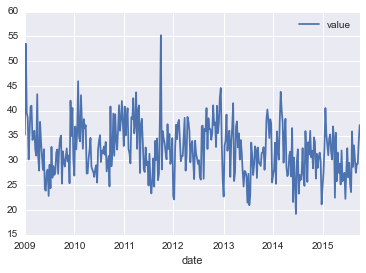

In [43]:
df_stations.set_index('date').resample('W', how='mean').plot()

## Ballungsräume

In [44]:
import json
from rtree import index

from shapely.geometry import shape, Point

class GeoIndex(object):
    def __init__(self, filename):
        with open(filename) as f:
            js = json.load(f)
        self.idx = index.Index()
        self.features = js['features']
    
        for i, feature in enumerate(self.features):
            polygon = shape(feature['geometry'])
            self.idx.insert(i, polygon.bounds)

    def covers(self, lat, lng):
        point = Point(lng, lat)
        for j in self.idx.intersection(point.coords[0]):
            polygon = shape(self.features[j]['geometry'])
            if point.within(polygon):
                yield self.features[j]['properties']
    
    def get_feature_property(self, lat, lng, prop):
        l = list(self.covers(lat, lng))
        if l:
            return l[0][prop]
        return None
    
gemeinde_index = GeoIndex('geodata/gemeinden_sim200.geojson')

In [45]:
ballungsraum = {
    'Freiburg': ['Freiburg im Breisgau', 'Umkirch'],
    'Karlsruhe': ['Karlsruhe', 'Ettlingen'],
    'Stuttgart': [u"Asperg", u"Bietigheim-Bissingen", u"Böblingen", u"Deizisau", u"Denkendorf", u"Ditzingen",
                  u"Esslingen am Neckar", u"Fellbach", u"Filderstadt", u"Freiberg am Neckar", u"Gerlingen",
                  u"Köngen", u"Korntal-Münchingen", u"Kornwestheim", u"Leinfelden-Echterdingen", u"Leonberg",
                  u"Ludwigsburg", u"Magstadt", u"Möglingen", u"Neuhausen auf den Fildern", u"Ostfildern",
                  u"Plochingen", u"Remseck am Neckar", u"Sindelfingen", u"Steinenbronn", u"Stuttgart", u"Tamm",
                  u"Wendlingen am Neckar", u"Wernau (Neckar)"],
    'Mannheim/Heidelberg': [u'Edingen-Neckarhausen', u'Eppelheim', u'Heidelberg', u'Ilvesheim', u'Ladenburg',
                            u'Mannheim', u'Plankstadt', u'Schwetzingen'],
    'Hamburg': ['Hamburg'],
    'Berlin': ['Berlin'],
}
reverse_ballungsraum = {v: k for k, vlist in ballungsraum.items() for v in vlist}

assign_geofeature = lambda idx, key: lambda x: idx.get_feature_property(x.lat, x.lng, key)

stations['gemeinde'] = stations.apply(assign_geofeature(gemeinde_index, 'GEN'), axis=1)

stations['ballungsraum'] = stations['gemeinde'].apply(lambda x: reverse_ballungsraum.get(x))

In [46]:
stations['gemeinde'].value_counts().head(10)

Hamburg              79
Berlin               67
Köln                 31
Essen                20
Frankfurt am Main    20
Duisburg             17
Düsseldorf           17
München              16
Gelsenkirchen        15
Castrop-Rauxel       12
dtype: int64

In [47]:
stations['ballungsraum'].value_counts()

Hamburg                79
Berlin                 67
Stuttgart              27
Mannheim/Heidelberg    10
Karlsruhe               8
Freiburg                6
dtype: int64

## Anzahl der 200 µg/m^3 Überschreitungen in den Ballungsräumen 2015 bis 30.9.

2015 und 2014

In [48]:
exceeding_200_count = (greater_200.groupby([greater_200.index.year, greater_200.Station.astype(str)])
                        .value.count().reset_index().rename(columns={'level_0': 'jahr', 'value': 'anzahl'}))

exceeding_200_in_2015 = exceeding_200_count[(exceeding_200_count.jahr == 2015)]
exceeding_100_stations_2015 = exceeding_200_in_2015.merge(stations, on='Station')
exceeding_100_stations_2015.groupby('ballungsraum').anzahl.sum()

ballungsraum
Berlin                  3
Hamburg                15
Karlsruhe               1
Mannheim/Heidelberg     2
Stuttgart              76
Name: anzahl, dtype: int64

In [54]:
exceeding_200_count = (greater_200.groupby([greater_200.index.year, greater_200.Station.astype(str)])
                        .value.count().reset_index().rename(columns={'level_0': 'jahr', 'value': 'anzahl'}))

exceeding_200_in_2014 = exceeding_200_count[(exceeding_200_count.jahr == 2014)]
exceeding_200_stations_2014 = exceeding_200_in_2014.merge(stations, on='Station')
exceeding_200_stations_2014.groupby('ballungsraum').anzahl.sum()

ballungsraum
Berlin       11
Hamburg      13
Karlsruhe     2
Stuttgart    56
Name: anzahl, dtype: int64

Überschreitungen von 100 im Jahr 2014 nach Ballungsraum:

In [50]:
exceeding_100_count = (greater_100.groupby([greater_100.index.year, greater_100.Station.astype(str)])
                        .value.count().reset_index().rename(columns={'level_0': 'jahr', 'value': 'anzahl'}))

exceeding_100_in_2014 = exceeding_100_count[(exceeding_100_count.jahr == 2014)]
exceeding_100_stations_2014 = exceeding_200_in_2015.merge(stations, on='Station')
exceeding_100_stations_2014.groupby('ballungsraum').anzahl.sum()

ballungsraum
Berlin       11
Hamburg      13
Karlsruhe     2
Stuttgart    56
Name: anzahl, dtype: int64

## Schlechtester Stationsdurchschnittswert in den Ballungsräumen

2015 und 2014

In [51]:
df[df.index.year == 2015].merge(stations[['Station', 'ballungsraum']], on='Station').groupby(['Station', 'ballungsraum']).mean().unstack().max()

       ballungsraum       
value  Berlin                 52.737807
       Freiburg               57.912218
       Hamburg                64.315990
       Karlsruhe              44.676853
       Mannheim/Heidelberg    46.640375
       Stuttgart              87.904302
dtype: float64

In [52]:
df[df.index.year == 2014].merge(stations[['Station', 'ballungsraum']], on='Station').groupby(['Station', 'ballungsraum']).mean().unstack().max()

       ballungsraum       
value  Berlin                 62.064815
       Freiburg               62.316244
       Hamburg                61.623688
       Karlsruhe              45.840860
       Mannheim/Heidelberg    48.253304
       Stuttgart              88.604405
dtype: float64

## Verlauf der Ballungsräume von 2014 - 2015 nach Wochenwerten

Schlimmste Station zu jeder Stunde im Ballungsraum, davon der Wochendurchschnitt.

In [69]:
week_max_2014_15 = df[df.index.year >= 2014].reset_index().merge(stations, on='Station').groupby(['date', 'ballungsraum']).value.max().unstack().resample('W', how=np.mean)

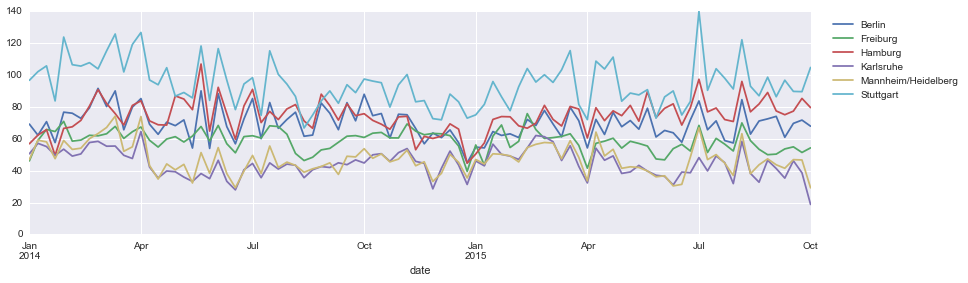

In [70]:
fig = plt.figure(figsize=(14, 4))
axes = fig.add_subplot(111)
week_max_2014_15.plot(ax=axes)
plt.legend(bbox_to_anchor=(1.2,1))